#  Приоритизация гипотез и анализ результатов A/B-теста

## Цель 

Приоритизировать гипотезы, проанализировать результаты A/B-теста.

## Ход проекта

1. Знакомство с данными
2. Исследоватеский анализ данных
3. Приоритизация гипотез
4. Анализ A/B-теста
5. Общий вывод

## Описание данных

Файл `/datasets/hypothesis.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/hypothesis.csv)

-   `Hypothesis` — краткое описание гипотезы;
-   `Reach` — охват пользователей по 10-балльной шкале;
-   `Impact` — влияние на пользователей по 10-балльной шкале;
-   `Confidence` — уверенность в гипотезе по 10-балльной шкале;
-   `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

**Данные для второй части**

Файл `/datasets/orders.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders.csv)

-   `transactionId` — идентификатор заказа;
-   `visitorId` — идентификатор пользователя, совершившего заказ;
-   `date` — дата, когда был совершён заказ;
-   `revenue` — выручка заказа;
-   `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visitors.csv)

-   `date` — дата;
-   `group` — группа A/B-теста;
-   `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста


## Загрузка и обзор данных

In [285]:
# импортируем необходимые для работы модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import datetime as dt

In [286]:
plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams["axes.formatter.limits"] = (-4,7)
import warnings
warnings.filterwarnings('ignore')
sns.set()
#plt.rcParams.keys()

In [287]:
# загрузим файл с данными в датафрейм hypothesis
try:
    hypothesis = pd.read_csv('hypothesis.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [288]:
# загрузим файл с данными в датафрейм orders
try:
    orders = pd.read_csv('orders.csv')
except:
    orders = pd.read_csv('/datasets/orders.csv')

In [289]:
# загрузим файл с данными в датафрейм visitors
try:
    visitors = pd.read_csv('visitors.csv')
except:
    visitors = pd.read_csv('/datasets/visitors.csv')

In [290]:
# посмотрим данные в таблице hypothesis
pd.set_option('display.max_colwidth', None)
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [291]:
# проверим на типы данных и пропущенные значения
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [292]:
# проверка на дубликаты
hypothesis.duplicated().sum()

0

In [293]:
# изменим названия столблцов таблицы hypothesis
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

In [294]:
# посмотрим данные в таблице orders
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [295]:
# проверим на типы данных и пропущенные значения
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [296]:
# изменим тип данных столбца data на datetime в orders
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [297]:
# проверка на дубликаты
orders.duplicated().sum()

0

In [298]:
# посмотрим уникальные значения в столбце group таблицы orders
orders.group.unique()

array(['B', 'A'], dtype=object)

In [299]:
# изменим названия столблцов таблицы orders
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [300]:
# посмотрим данные в таблице visitors
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [301]:
# изменим тип данных столбца data на datetime в visitors
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [302]:
# проверим на типы данных и пропущенные значения
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [303]:
# проверка на дубликаты
visitors.duplicated().sum()

0

In [304]:
# посмотрим уникальные значения в столбце group таблицы visitors
visitors.group.unique()

array(['A', 'B'], dtype=object)

Загрузили данные в датафреймы. Провели проверки типов данных, на дубликатыб на пропущенные значения, исправили названия столбцов.

## Исследовательский анализ

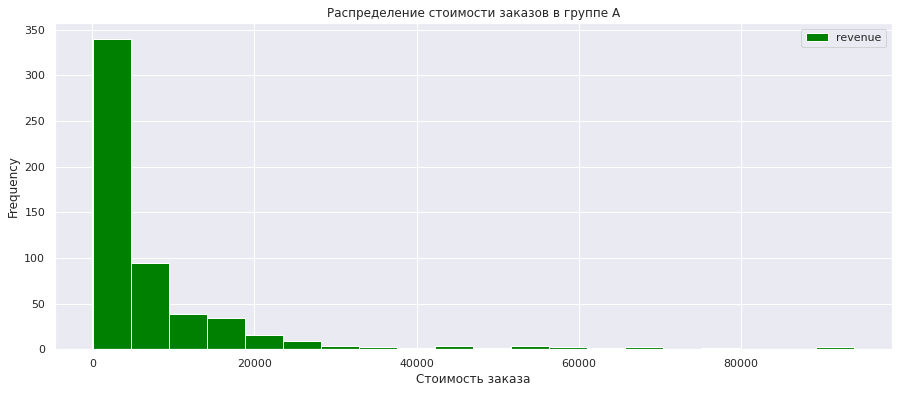

In [305]:
# построим гистограмму выручки в группе А
orders[orders['group']=='A'].plot(x='date', y='revenue', color='green', kind='hist', bins=20,
                                 title='Распределение стоимости заказов в группе А')
plt.xlabel('Стоимость заказа')
plt.show()

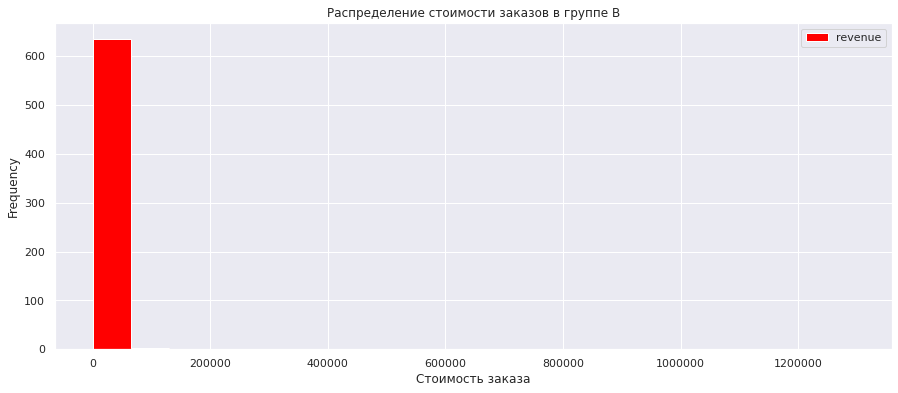

In [306]:
# построим гистограмму выручки в группе B
orders[orders['group']=='B'].plot(x='date', y='revenue', color='red', kind='hist', bins=20,
                                 title='Распределение стоимости заказов в группе B')
plt.xlabel('Стоимость заказа')
plt.show()

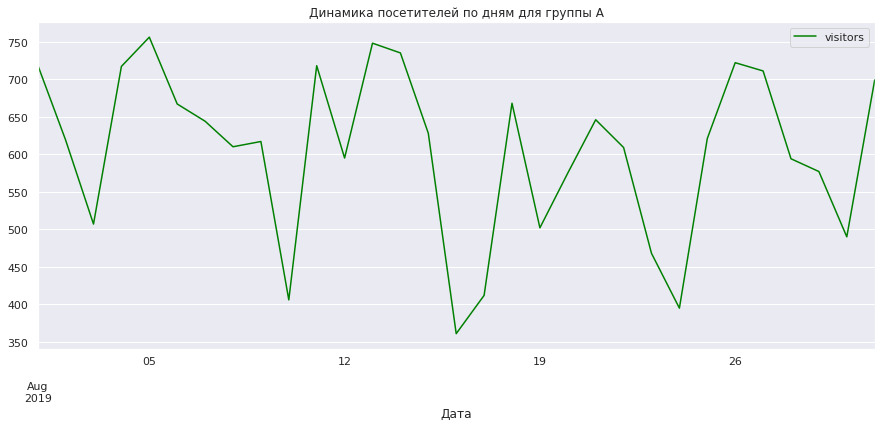

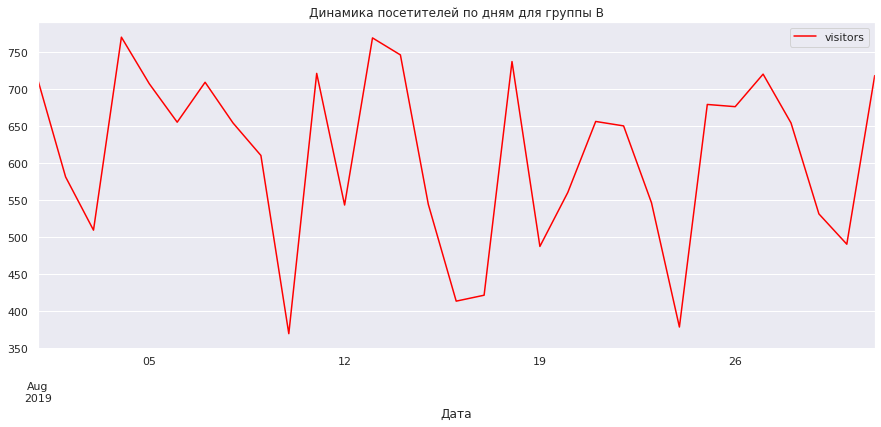

In [307]:
# помотрим динамику посетителей по дням
visitors[visitors['group']=='A'].plot(x='date', y='visitors', color='green')
plt.title('Динамика посетителей по дням для группы А')
plt.xlabel('Дата')
visitors[visitors['group']=='B'].plot(x='date', y='visitors', color='red')
plt.title('Динамика посетителей по дням для группы В')
plt.xlabel('Дата')
plt.show()

В таблице orders есть выбросы. Разберемся с ними позже.

## Приоретизация гипотез

### Приоритизация по ICE

In [308]:
# рассчитаем score для каждой гипотезы по фреймворку ICE
hypothesis['ICE'] = round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'],1)
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


### Приоритизация по RICE

In [309]:
# рассчитаем score для каждой гипотезы по фреймворку RICE
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,3.0


При применении фреймворка RICE после ICE изменился порядок приоритетности гипотез.     

Так произошло потому что **RICE учитывает оценку охвата изменений, а ICE - нет.** То есть на какое количество пользователей повлияет внедрение данных изменений.     

Таким образом гипотеза `"Запустить акцию, дающую скидку на товар в день рождения"`, например, упала в приоритете с 1 на 5 позицию, так как охватывает только пользователей, у которых сегодня день рождение.

## Анализ A/B-теста

###  График кумулятивной выручки по группам

In [310]:
# подготавливаем данные для построения графиков
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated=datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

visitorsAggregated=datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


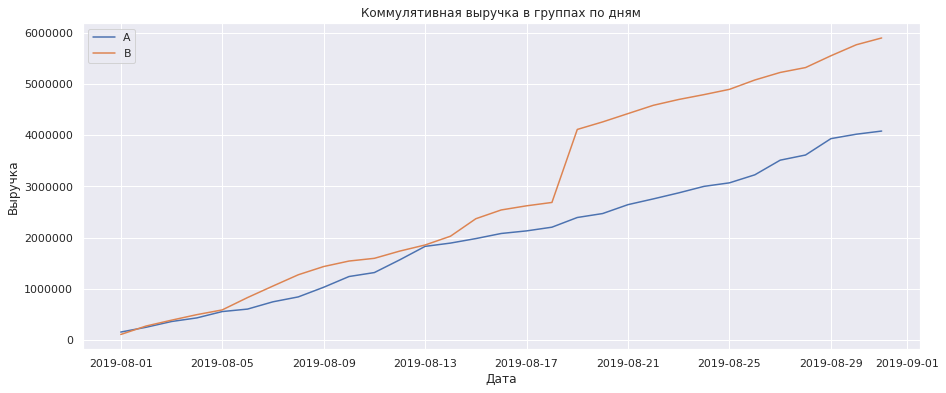

In [311]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Коммулятивная выручка в группах по дням')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend() 
plt.show()

Выручка по группам изначально примерно одинаковая. Но примерно после 2019-08-17 есть большой скачок, который обуславливает сильное различие в выручке к концу теста.

**Такой резкий рост выручки для группы B может быть обусловленно одной крупной продажей, выбросом.**



### График кумулятивного среднего чека по группам

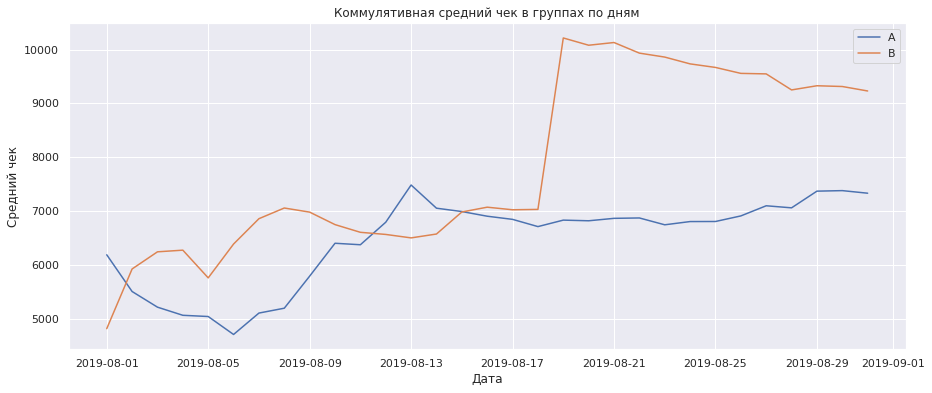

In [312]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('Коммулятивная средний чек в группах по дням')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend() 
plt.show()

Здесь мы также видим, что резко вырос средний чек. Вероятная причина в крупной продаже.

В первое время после запуска теста средний чек группы B вырос по отношению к группе А.
Затем был резкий скачек примерно 2019-08-18 в показателе среднего чека для группы B.
После скачка средний чек группы B падает, а группы А - растет. 

При исключении нетипичных крупных сделок-выбросов мы скорее всего получим, что показатели среднего чека с 2019-08-13 колеблются в достаточно узком диапазоне в 1000 руб и начинают стабилизироваться. 

При возможности для получения более точных результатов стоит поднакопить еще данных.

### График относительного изменения кумулятивного среднего чека группы B к группе A

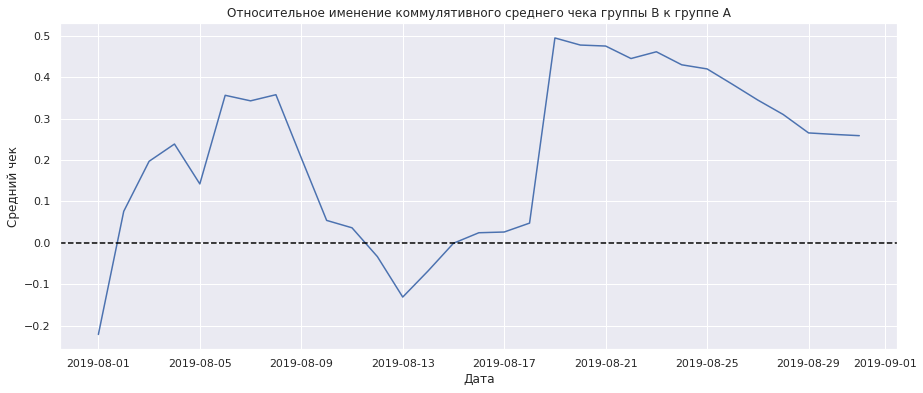

In [313]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Относительное именение коммулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()

Сначала средний чек группы В к группе А рос, потом падал, затем был резкий рост и снова падение. 

Главный вопрос все еще остается за причиной резкого роста.

### График кумулятивного среднего количества заказов на посетителя по группам

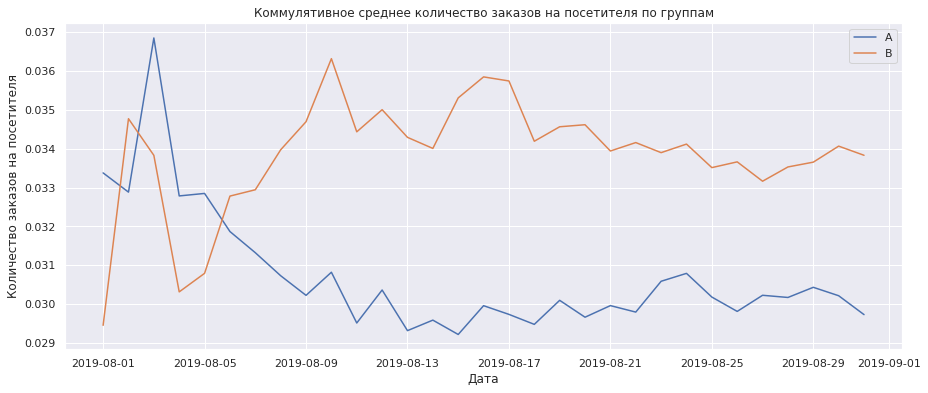

In [314]:
 #считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Коммулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов на посетителя')
plt.legend() 
plt.show()


Количеству заказов на посетителя в группе А падает и стабилизируется по сравнению с группой В.

Таким образом в разрезе количества заказов на посетителя группа B - лучше.


### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

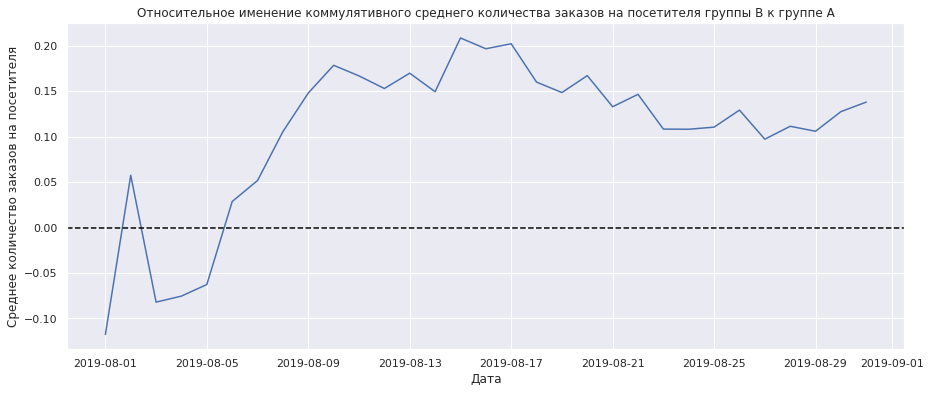

In [315]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', right_on='date', how='left',
                                                                           suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')


plt.title('Относительное именение коммулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя')
plt.show()

Метрика в группе В стабильно больше по отношению к группе А.

### Точечный график количества заказов по пользователям

In [316]:
# построим таблицу ordersByUsers
ordersByUsers = (
    orders.groupby('visitor_id')
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['orders']
ordersByUsers = ordersByUsers.reset_index()
ordersByUsers.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


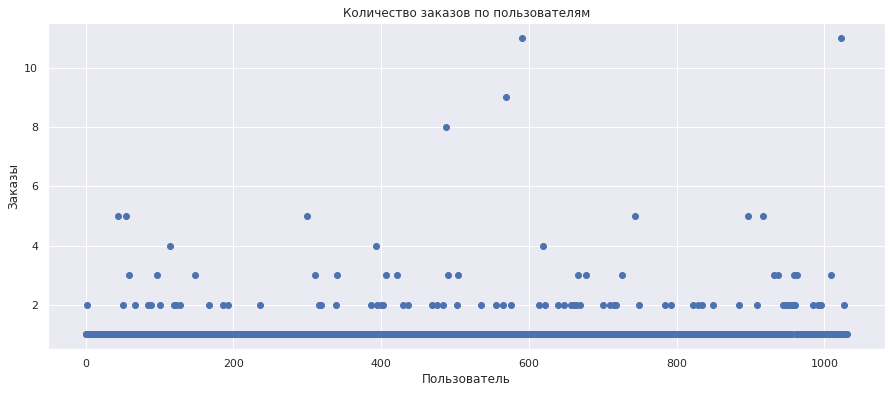

In [317]:
# построим точечный график количества заказов по пользователям
plt.scatter(ordersByUsers.index, ordersByUsers['orders']) 
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователь')
plt.ylabel('Заказы')
plt.show()

По графику мы видим, что количество пользователей с числом заказов больше 3 не много. **Большинство пользователей делают до 2 заказов включительно.**

### 95-й и 99-й перцентили количества заказов на пользователя

In [318]:
# посчитаем 95 и 99 процентили по количеству закзов на пользователя
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


**В качестве границы для определения аномальных пользователей выберем пользователей с числом заказов более 2.**

###  Точечный график стоимостей заказов

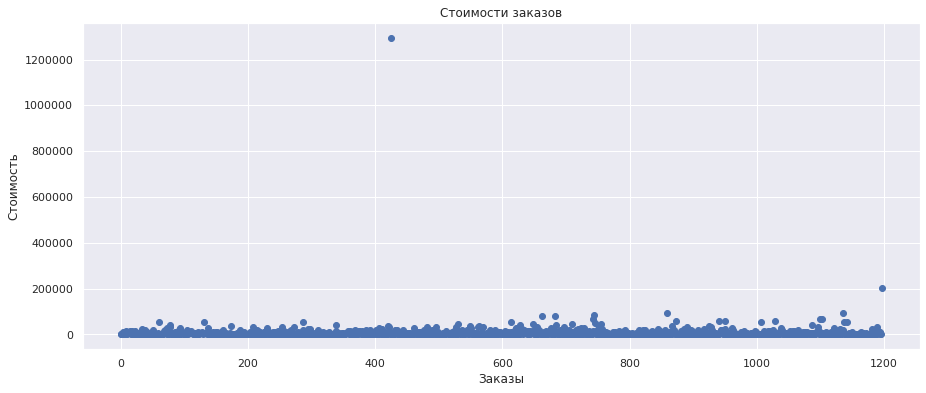

In [319]:
# построим точечный график стоимостей заказов
plt.scatter(orders.index, orders['revenue']) 
plt.title('Стоимости заказов')
plt.xlabel('Заказы')
plt.ylabel('Стоимость')
plt.show()

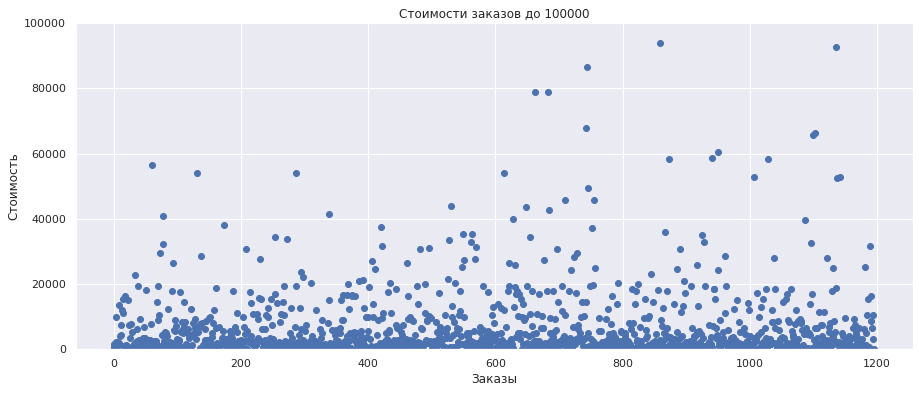

In [320]:
# построим точечный график стоимостей заказов без выбросов 
plt.scatter(orders.index, orders['revenue']) 
plt.title('Стоимости заказов до 100000')
plt.xlabel('Заказы')
plt.ylabel('Стоимость')
plt.ylim([0, 100000])
plt.show()

Подтверждается наше предположение о выбрасах в стоимости заказа.

По графику видим, что есть **2 нетипичных заказа явно выделяющихся по стоимости.**

### 95-й и 99-й перцентили стоимости заказов

In [321]:
# посчитаем 95 и 99 процентили по стоимостям заказов
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


**В качестве границы для определения аномальных заказов выберем заказы со стоимостью более 28000.**

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [322]:
# подготовим данные для анализа
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitor_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitor_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              20           148579              20   
1 2019-08-02              19            93822              23   
2 2019-08-03              24           112473              16   
3 2019-08-04              15            70825              16   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  20               148579   
1           165531                  39               242401   
2           114248                  63               354874   
3           108571                  78               425699   
4            92428                 103               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  20               101217               719   
1                  43               266748               619   
2                  59               38

Так как признаки у нас измерены количественно и выборки независимы - **используем для расчета статистической значимости критерий Манна-Уитни.**


H0: группы статистически единтичны в среднем количестве заказов на посетителя по «сырым» данным

H1: группы статистически различны в среднем количестве заказов на посетителя по «сырым» данным

In [323]:
alpha = 0.05  # критический уровень статистической значимости

p_value = stats.mannwhitneyu(sampleA, sampleB)[1]

print("P-value:{0:.5f}".format(p_value))
print()

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между группами есть статистические различия в среднем количестве заказов на посетителя по «сырым» данным')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий  в среднем количестве заказов на посетителя по «сырым» данным между группами нет') 
print()

print("Относительное различие:{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))
    

P-value:0.01679

Отвергаем нулевую гипотезу: между группами есть статистические различия в среднем количестве заказов на посетителя по «сырым» данным

Относительное различие:0.146


По результатам теста на "сырых" данных получилось, что выборки различны. 

**Есть статистически значимый рост среднего количества заказов на посетителя в группе В по отношению к группе А. 
Рост составляет 14,6%.**

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

In [324]:
alpha = 0.05  # критический уровень статистической значимости

results = stats.shapiro(sampleA)
p_value = results[
    1
]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


H0: группы статистически единтичны в размере среднего чека по «сырым» данным

H1: группы статистически различны в размере среднего чека по «сырым» данным

In [325]:
alpha = 0.05  # критический уровень статистической значимости

p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print('P-value:{0:.3f}'.format(p_value))
print()
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между группами есть статистические различия в размере среднего чека по «сырым» данным')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в размере среднего чека по «сырым» данным между группами нет') 
print()
print('Относительное различие:{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value:0.729

Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в размере среднего чека по «сырым» данным между группами нет

Относительное различие:0.259


**По результатам теста на "сырых" данных получилось, что статистических различий между выборками нет.**


Однако относительное различие между группами в среднем размере чека на "сырых" данных составляет 25,9%.



### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [326]:
# подготовим список id посетителей с количеством заказов больше 2 и стоимостью больше 28000
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head())

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64


In [327]:
# подготовим отфильтрованные выборки
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 


H0: группы статистически единтичны в среднем количестве заказов на посетителя по «очищенным» данным

H1: группы статистически различны в среднем количестве заказов на посетителя по «очищенным» данным

In [328]:
alpha = 0.05  # критический уровень статистической значимости

p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

print("P-value:{0:.5f}".format(p_value))
print()

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между группами есть статистические различия')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий между группами нет') 
print()

print("Относительное различие:{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))
 

P-value:0.01304

Отвергаем нулевую гипотезу: между группами есть статистические различия

Относительное различие:0.173


По результатам теста на "очищеных" данных получилось, что выборки различны. 

**Есть статистически значимый рост среднего количества заказов на посетителя в группе В по отношению к группе А. 
Рост составляет 17,3%.**



### Статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

H0: группы статистически единтичны в размере среднего чека по «очищенным» данным

H1: группы статистически различны в размере среднего чека по «очищенным» данным

In [329]:
alpha = 0.05  # критический уровень статистической значимости

p_value =  stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]


print(
    'P-value:{0:.3f}'.format(p_value
       
    )
)
print()

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между группами есть статистические различия')
else:
    print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий между группами нет') 
print()
print(
    "Относительное различие:{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 




P-value:0.738

Не получилось отвергнуть нулевую гипотезу, статистически значимых различий между группами нет

Относительное различие:-0.020


**По результатам теста на "очищенных" данных получилось, что статистических различий между выборками нет.**


Однако относительное различие между группами в среднем размере чека на "очищенных" данных составляет -2%. Это похоже на правду и дополнительно подтверждает, что **по результатам АБ теста изменений в сумме среднего чека не произошло.** 

На сильное относительное различие при оценке на "сырых" данных повлияли выбросы.

## Вывод

- **Есть статистические различия по среднему количеству заказов на посетителя, как по сырым, так и по очищенным данным.** Группа B лучше на 14,6%

- **Нет статистически значимых различий между группами в размере среднего чека.**

- **График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A и метрика к концу теста устойчива.**

- График различия среднего чека говорит о том, что результаты группы B значительно лучше группы А. Но на графике явно заметно влияние нескольких крупных заказов, выбросов. Из отсутствия статистических различий по размеру среднего чека  и относительного различия в  2% можно сделать вывод, что **различие между группами по размеру среднего чека стремиться к нулю.**


***Тест можно остановить, зафиксировав победу группы B.***

***Среднеее количество заказов на посетителя выросло на 17,3% при неизменном чеке.***
